In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import nltk
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

In [3]:
df = pd.read_csv('crawling_beer_data.csv', header=0, sep=',', thousands=',', encoding='latin-1') 

In [4]:
df.head()

,Primary_Style,Min_IBU,Max_IBU,Main_Style,Name,Brewery,Country,ABV,Web_Score,Average_Score,Num_of_reviews,Num_of_ratings,Notes
0,Bock,20,30,Bocks,Shiner Bock,Spoetzl Brewery,"Texas, United States",4.50%,74.0,3.21,1220,3299,Tip back a bock. Brewed with rich roasted barl...
1,Bock,20,30,Bocks,Samuel Adams Chocolate Bock,Boston Beer Company (Samuel Adams),"Massachusetts, United States",5.80%,82.0,3.64,1247,1895,"Rich & DecadentThis rich, decadent bock has a ..."
2,Bock,20,30,Bocks,Michelob AmberBock,Anheuser-Busch,"Missouri, United States",5.20%,68.0,2.91,724,1231,Michelob AmberBock is brewed using 100% malt i...
3,Bock,20,30,Bocks,Samuel Adams Cherry Chocolate Bock,Boston Beer Company (Samuel Adams),"Massachusetts, United States",5.80%,79.0,3.47,188,687,None
4,Bock,20,30,Bocks,St. Nikolaus Bock Bier,Pennsylvania Brewing Company,"Pennsylvania, United States",6%,88.0,3.94,225,220,Munich and various roasted malts give it a ver...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210888 entries, 0 to 210887
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Primary_Style   210888 non-null  object 
 1   Min_IBU         210888 non-null  int64  
 2   Max_IBU         210888 non-null  int64  
 3   Main_Style      210888 non-null  object 
 4   Name            210886 non-null  object 
 5   Brewery         210888 non-null  object 
 6   Country         210851 non-null  object 
 7   ABV             210888 non-null  object 
 8   Web_Score       34798 non-null   float64
 9   Average_Score   210888 non-null  float64
 10  Num_of_reviews  210888 non-null  int64  
 11  Num_of_ratings  210888 non-null  int64  
 12  Notes           210885 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 20.9+ MB


In [6]:
df.shape

(210888, 13)

# 1.Data Handling

In [7]:
df_copy = df.copy()

In [8]:
df_copy['ABV']=df_copy['ABV'].str.replace('%','')
df_copy['ABV']=df_copy['ABV'].replace('Not listed',np.nan)
df_copy['ABV'] = pd.to_numeric(df_copy['ABV'])

In [9]:
df_copy = df_copy.dropna()

In [10]:
df_copy = df_copy.drop_duplicates()

In [11]:
df_copy.loc[df_copy['Country'].str.contains('United States'), 'Country'] = 'United States'
df_copy.loc[df_copy['Country'].str.contains('Canada'), 'Country'] = 'Canada'
df_copy.loc[df_copy['Country'].str.contains('United Kingdom'), 'Country'] = 'United Kingdom'

In [12]:
df_copy.shape

(34641, 13)

In [13]:
#outliers

In [14]:
df_copy.describe(include='all')

,Primary_Style,Min_IBU,Max_IBU,Main_Style,Name,Brewery,Country,ABV,Web_Score,Average_Score,Num_of_reviews,Num_of_ratings,Notes
count,34641,34641.000000,34641.000000,34641,34641,34641,34641,34641.000000,34641.000000,34641.000000,34641.000000,34641.000000,34641
unique,120,NaN,NaN,14,32523,4513,111,NaN,NaN,NaN,NaN,NaN,20302
top,American IPA,NaN,NaN,India Pale Ales,Oktoberfest,Tree House Brewing Company,United States,NaN,NaN,NaN,NaN,NaN,None
freq,4560,NaN,NaN,11417,136,481,27902,NaN,NaN,NaN,NaN,NaN,14246
mean,NaN,32.468895,53.702434,NaN,NaN,NaN,NaN,7.020605,87.239860,3.890737,54.909125,132.158425,NaN
std,NaN,18.957733,25.112321,NaN,NaN,NaN,NaN,2.342193,5.722272,0.359649,191.946094,482.874318,NaN
min,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.010000,43.000000,1.650000,0.000000,1.000000,NaN
25%,NaN,18.000000,30.000000,NaN,NaN,NaN,NaN,5.300000,85.000000,3.710000,5.000000,11.000000,NaN
50%,NaN,25.000000,50.000000,NaN,NaN,NaN,NaN,6.500000,88.000000,3.930000,9.000000,22.000000,NaN
75%,NaN,50.000000,70.000000,NaN,NaN,NaN,NaN,8.000000,91.000000,4.140000,27.000000,67.000000,NaN


<AxesSubplot:xlabel='ABV'>

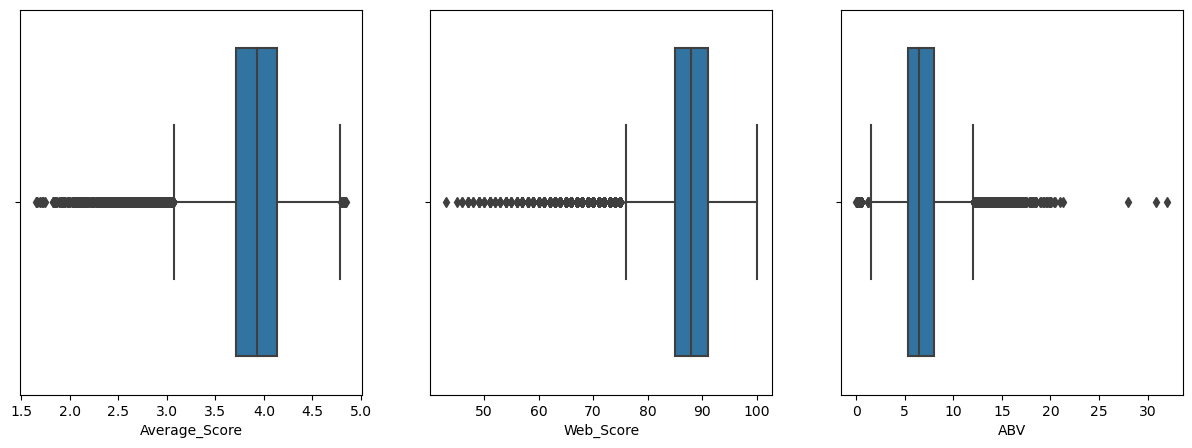

In [15]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(df_copy.Average_Score, ax=axes[0])
sns.boxplot(df_copy.Web_Score, ax=axes[1])
sns.boxplot(df_copy.ABV, ax=axes[2])

<AxesSubplot:xlabel='Max_IBU'>

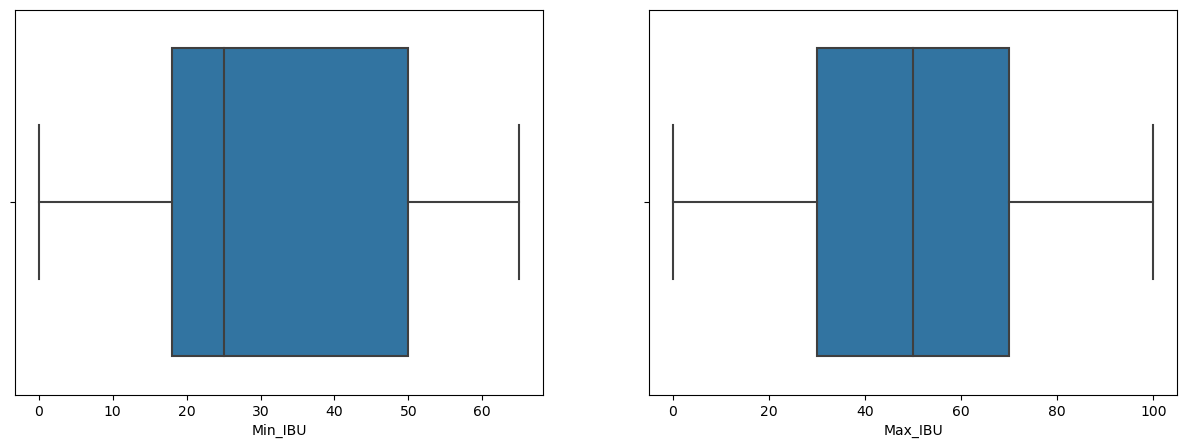

In [16]:
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(df_copy.Min_IBU, ax=axes[0])
sns.boxplot(df_copy.Max_IBU, ax=axes[1])

In [17]:
#no need to handle outliers, the amount is the amount they are true outliers

In [18]:
# save cleaned data to csv file
df_copy.to_csv('cleaned_beer_data.csv', index=False)

# 2.EDA & Visualization

In [19]:
cdf = pd.read_csv('cleaned_beer_data.csv', header=0, sep=',', thousands=',', encoding='latin-1') 

In [20]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34641 entries, 0 to 34640
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Primary_Style   34641 non-null  object 
 1   Min_IBU         34641 non-null  int64  
 2   Max_IBU         34641 non-null  int64  
 3   Main_Style      34641 non-null  object 
 4   Name            34641 non-null  object 
 5   Brewery         34641 non-null  object 
 6   Country         34641 non-null  object 
 7   ABV             34641 non-null  float64
 8   Web_Score       34641 non-null  float64
 9   Average_Score   34641 non-null  float64
 10  Num_of_reviews  34641 non-null  int64  
 11  Num_of_ratings  34641 non-null  int64  
 12  Notes           34641 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 3.4+ MB


<AxesSubplot:title={'center':'Number of Beers by Country (Top 10 countries)'}>

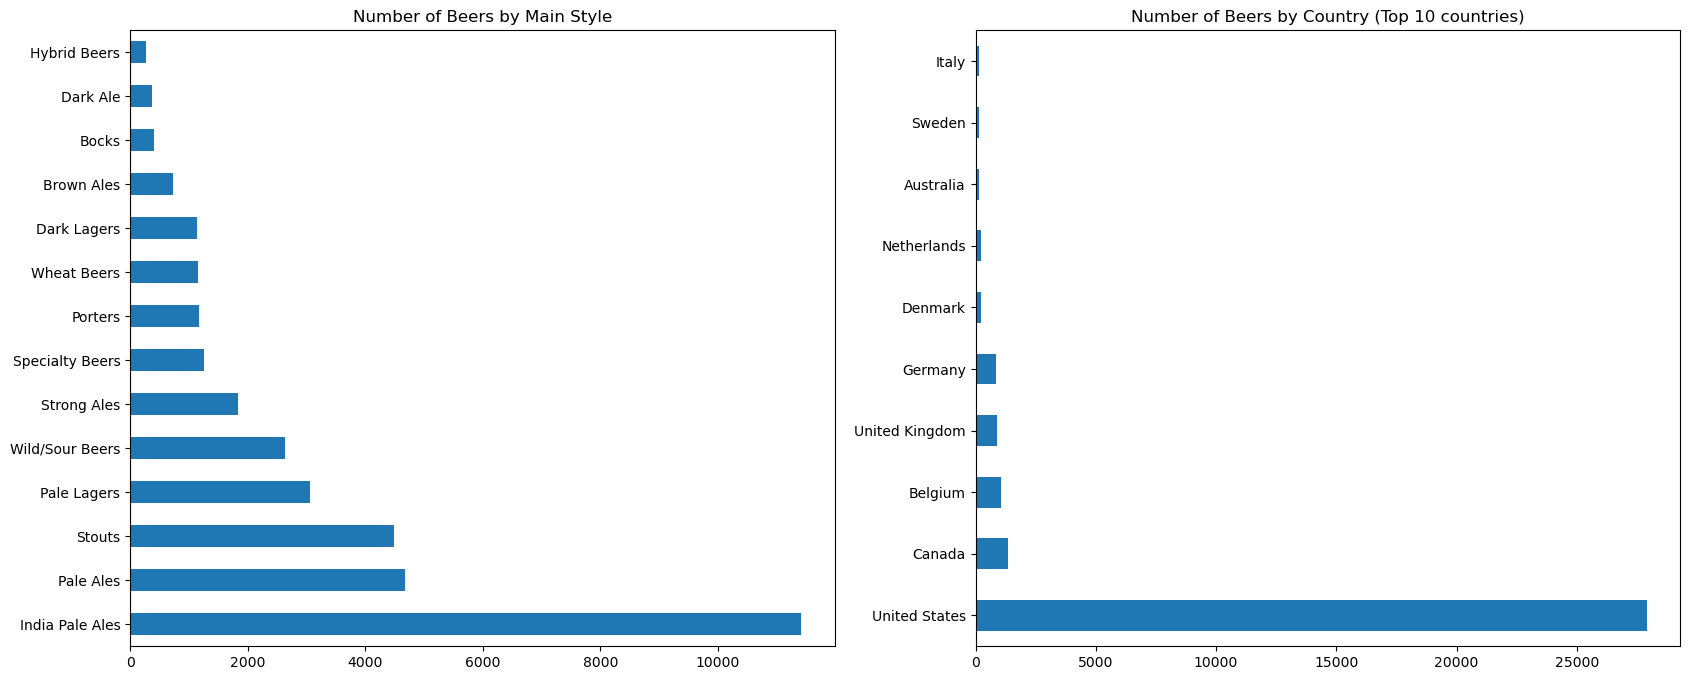

In [21]:
f, axes = plt.subplots(1, 2, figsize=(20,8))
cdf['Main_Style'].value_counts().plot(kind='barh', ax=axes[0], title='Number of Beers by Main Style' )
cdf['Country'].value_counts()[cdf['Country'].value_counts() > 125].plot(kind='barh', ax=axes[1], title='Number of Beers by Country (Top 10 countries)')

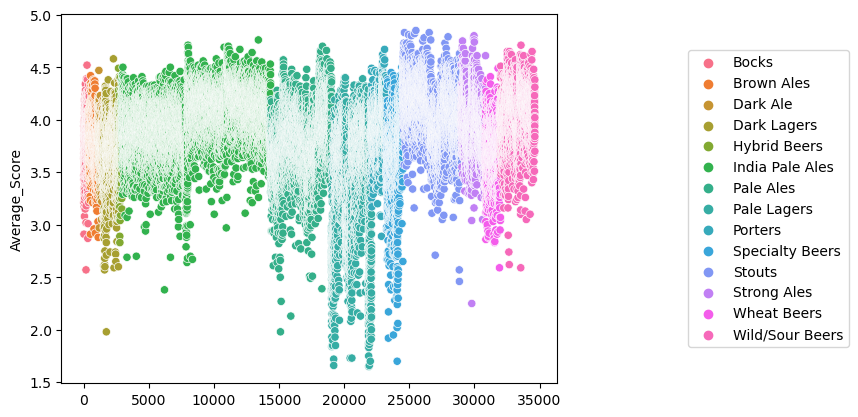

In [72]:
sns.scatterplot(data=cdf, x=cdf.index, y='Average_Score', hue = 'Main_Style')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

Text(0, 0.5, 'Frequency')

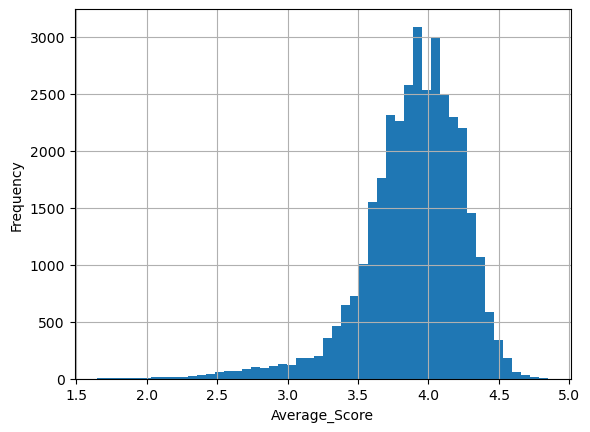

In [22]:
cdf['Average_Score'].hist(bins=50)
plt.xlabel('Average_Score')
plt.ylabel('Frequency')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '3.85'),
  Text(1, 0, '3.86'),
  Text(2, 0, '3.87'),
  Text(3, 0, '3.88'),
  Text(4, 0, '3.89'),
  Text(5, 0, '3.9'),
  Text(6, 0, '3.91'),
  Text(7, 0, '3.92'),
  Text(8, 0, '3.93'),
  Text(9, 0, '3.94'),
  Text(10, 0, '3.95'),
  Text(11, 0, '3.98'),
  Text(12, 0, '3.99'),
  Text(13, 0, '4.0'),
  Text(14, 0, '4.02'),
  Text(15, 0, '4.03'),
  Text(16, 0, '4.06'),
  Text(17, 0, '4.07'),
  Text(18, 0, '4.08'),
  Text(19, 0, '4.1'),
  Text(20, 0, '4.12'),
  Text(21, 0, '4.13'),
  Text(22, 0, '4.14'),
  Text(23, 0, '4.15'),
  Text(24, 0, '4.16')])

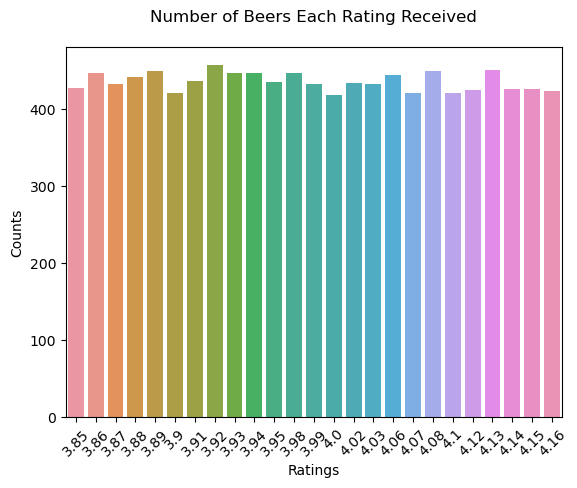

In [23]:
sns.barplot(cdf['Average_Score'].value_counts().head(25).index, cdf['Average_Score'].value_counts().head(25))
plt.title('Number of Beers Each Rating Received\n')
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.xticks(rotation=45)

<AxesSubplot:xlabel='Num_of_ratings', ylabel='Name'>

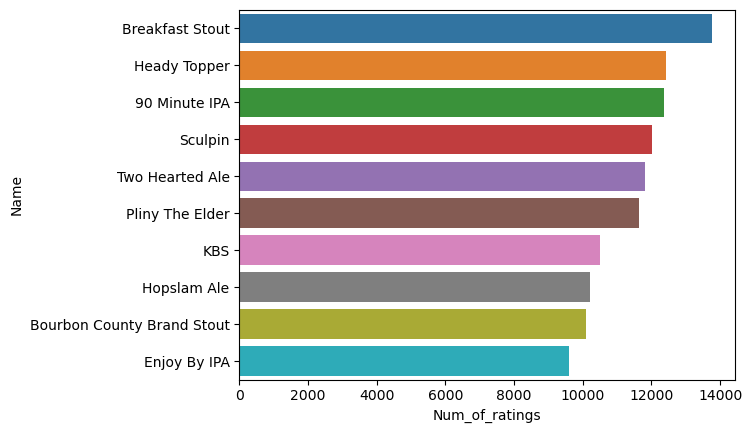

In [24]:
# highest rated beers
popular_beers = cdf.nlargest(10, ['Num_of_ratings']).set_index('Name')['Num_of_ratings']
sns.barplot(popular_beers, popular_beers.index)

<AxesSubplot:xlabel='Num_of_reviews', ylabel='Name'>

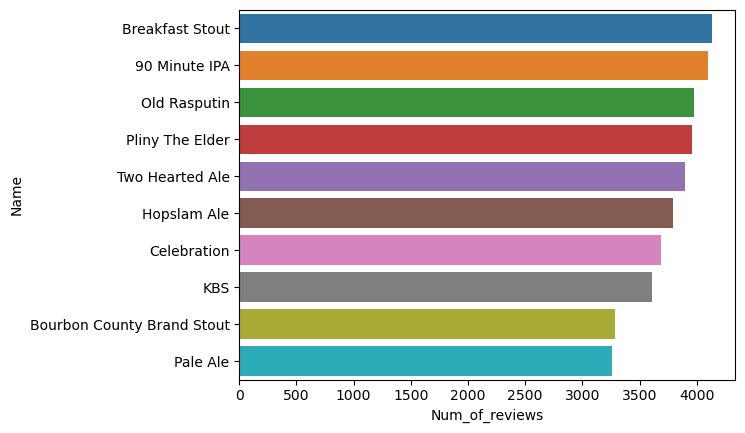

In [25]:
#highest reviewed beers
highest_reviews = cdf.nlargest(10, ['Num_of_reviews'])
sns.barplot(highest_reviews['Num_of_reviews'], highest_reviews['Name'])

Text(0.5, 0, 'Number of beers')

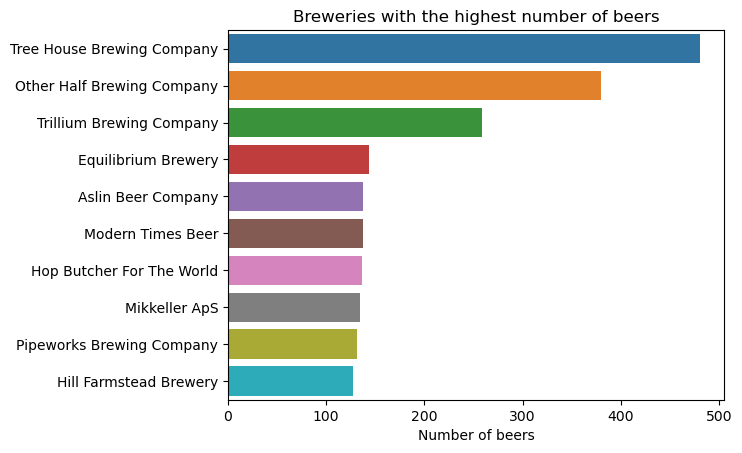

In [26]:
# Breweries with the highest number of beers
top_breweries = cdf['Brewery'].value_counts().head(10)
sns.barplot(top_breweries, top_breweries.index)
plt.title('Breweries with the highest number of beers')
plt.xlabel('Number of beers')

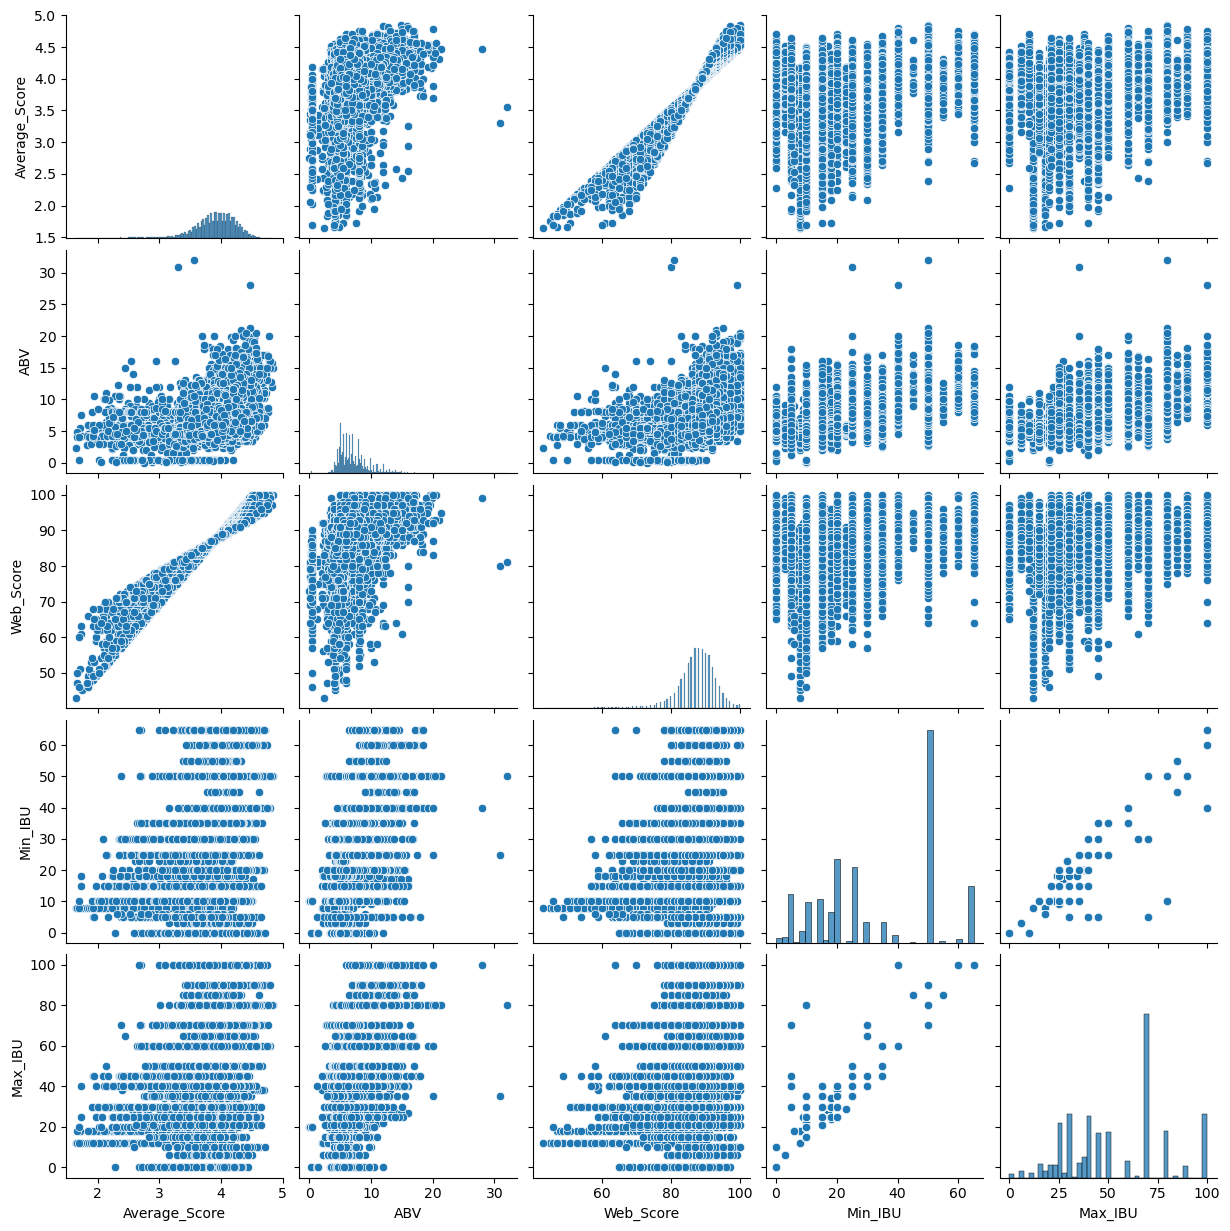

In [68]:
sns.pairplot(cdf[['Average_Score', 'ABV','Web_Score', 'Min_IBU', 'Max_IBU']])

<AxesSubplot:xlabel='Average_Score'>

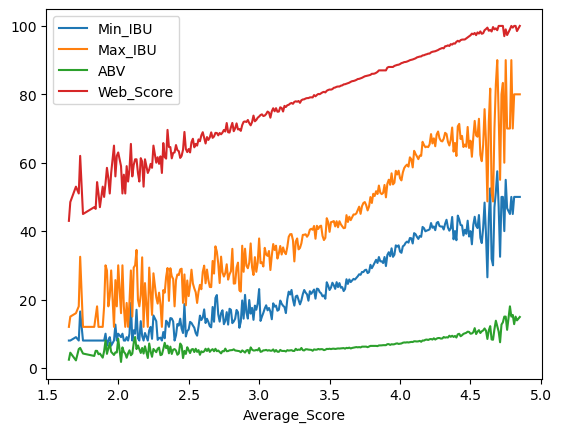

In [28]:
p =cdf.groupby(['Average_Score']).mean()[['Min_IBU','Max_IBU','ABV','Web_Score']]
p.plot()

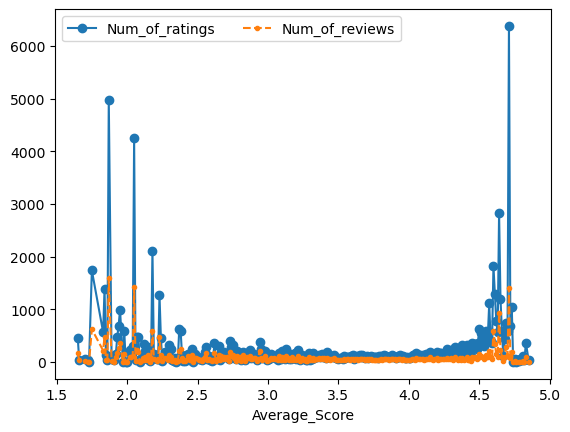

In [29]:
t =cdf.groupby(['Average_Score']).mean()[['Num_of_ratings', 'Num_of_reviews']]
t.plot(style=['o-','.--']).legend(loc='upper left', ncol=2)

In [ ]:
# text visualization
# not for research use

In [30]:
notes = cdf['Notes']
notes=notes.replace('None ',np.nan)
notes = notes.dropna()

In [31]:
def transform_format(val):
    if val != 0:
        return 255
    else:
        return val

In [32]:
lines = []
for line in notes:
    line = line.strip().lower()
    if len(line)==0:
        continue
    lines.append(line)
text = " ".join(lines)

In [33]:
image_file=Image.open(r"C:\Users\nivna\Desktop\beer-black-jar-shape-from-side-view-svgrepo-com (2).png")
# image_file=Image.open(r"C:\Users\nivna\Desktop\brand-untappd-svgrepo-com.png")
image_file=image_file.convert('1')
beer_mask = np.array(image_file)
transformed_beer_mask = np.ndarray((beer_mask.shape[0],beer_mask.shape[1]), np.int32)
for i in range(len(beer_mask)):
    transformed_beer_mask[i] = list(map(transform_format, beer_mask[i]))

In [34]:
stopwords = set(STOPWORDS)
stopwords.update(['ã','â','n','s','u'])

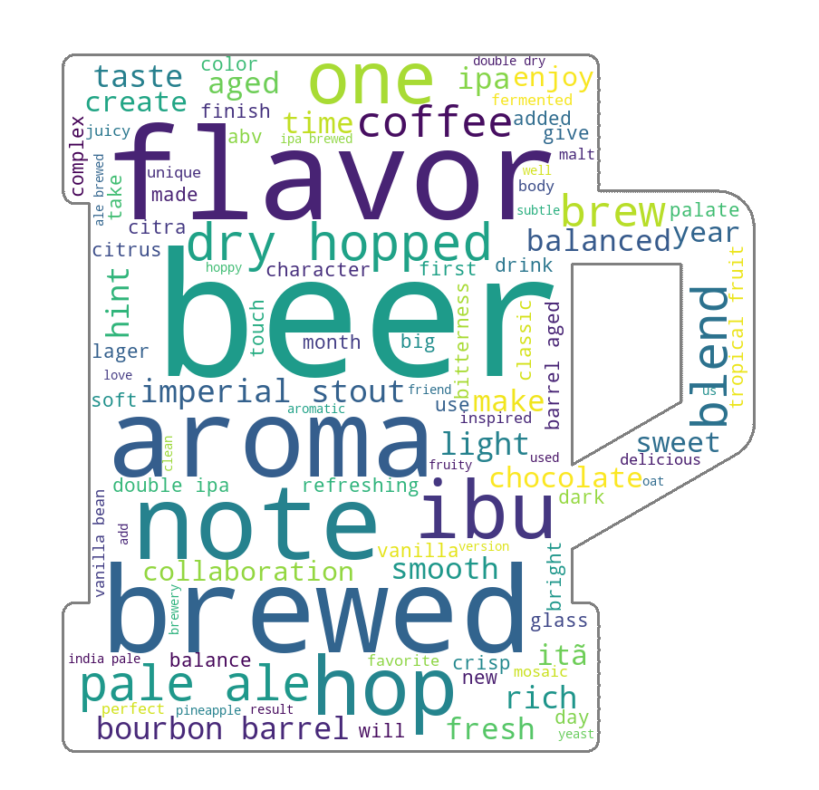

In [35]:
wc = WordCloud(background_color="white", max_words=100, mask=transformed_beer_mask,stopwords=stopwords, contour_width=3, contour_color='gray')
wc=wc.generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 4.Machine Learning

In [36]:
mldf = cdf.copy()

In [37]:
le = preprocessing.LabelEncoder()
mldf['Brewery'] = le.fit_transform(mldf['Brewery'])
mldf['Name'] = le.fit_transform(mldf['Name'])
mldf['Main_Style'] = le.fit_transform(mldf['Main_Style'])
mldf['Primary_Style'] = le.fit_transform(mldf['Primary_Style'])
mldf['Country'] = le.fit_transform(mldf['Country'])

In [38]:
mldf=mldf.drop('Notes', axis=1)

In [39]:
mldf

,Primary_Style,Min_IBU,Max_IBU,Main_Style,Name,Brewery,Country,ABV,Web_Score,Average_Score,Num_of_reviews,Num_of_ratings
0,27,20,30,0,25662,3739,105,4.5,74.0,3.21,1220,3299
1,27,20,30,0,24883,611,105,5.8,82.0,3.64,1247,1895
2,27,20,30,0,18614,179,105,5.2,68.0,2.91,724,1231
3,27,20,30,0,24881,611,105,5.8,79.0,3.47,188,687
4,27,20,30,0,27099,3138,105,6.0,88.0,3.94,225,220
...,...,...,...,...,...,...,...,...,...,...,...,...
34636,117,5,30,13,2231,3571,105,6.6,92.0,4.38,4,6
34637,117,5,30,13,20523,253,105,6.0,89.0,4.02,5,5
34638,117,5,30,13,3739,3128,105,4.6,87.0,3.84,0,10
34639,117,5,30,13,17657,982,80,4.2,85.0,3.70,4,6


In [40]:
#dataframe for the feature vectors (without the target column) and a series containing the corresponding target values 
X_columns = mldf.columns[mldf.columns!='Average_Score']
X = mldf[X_columns]
y = mldf['Average_Score']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [42]:
#train model
trained_model = LinearRegression()
trained_model.fit(X_train,y_train)

LinearRegression()

In [43]:
predictions = trained_model.predict(X_test)

In [44]:
r2_score(y_test, predictions)

0.9599373687626908

In [45]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})
pred.head(15)

,Actual,Predicted
0,3.70,3.692114
1,4.09,4.055656
2,3.89,3.869424
3,4.08,4.136890
4,3.84,3.834587
5,3.59,3.670601
6,4.13,4.112080
7,3.94,3.911009
8,4.00,3.960199
9,3.97,3.967338


In [ ]:
#try different model without the 'Web_Score' column

In [46]:
X1 = X.drop('Web_Score', axis=1)

In [47]:
X1

,Primary_Style,Min_IBU,Max_IBU,Main_Style,Name,Brewery,Country,ABV,Num_of_reviews,Num_of_ratings
0,27,20,30,0,25662,3739,105,4.5,1220,3299
1,27,20,30,0,24883,611,105,5.8,1247,1895
2,27,20,30,0,18614,179,105,5.2,724,1231
3,27,20,30,0,24881,611,105,5.8,188,687
4,27,20,30,0,27099,3138,105,6.0,225,220
...,...,...,...,...,...,...,...,...,...,...
34636,117,5,30,13,2231,3571,105,6.6,4,6
34637,117,5,30,13,20523,253,105,6.0,5,5
34638,117,5,30,13,3739,3128,105,4.6,0,10
34639,117,5,30,13,17657,982,80,4.2,4,6


In [48]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state = 42)

In [49]:
#train model
trained_model = LinearRegression()
trained_model.fit(X_train1,y_train1)

LinearRegression()

In [50]:
predictions1 = trained_model.predict(X_test1)

In [51]:
r2_score(y_test1, predictions1)

0.3461487700667748

In [52]:
pred1 = pd.DataFrame({'Actual': y_test1.tolist(), 'Predicted': predictions1.tolist()})
pred1.head(15)

,Actual,Predicted
0,3.70,3.817823
1,4.09,3.838674
2,3.89,3.768136
3,4.08,4.153076
4,3.84,3.522364
5,3.59,3.690960
6,4.13,3.801714
7,3.94,3.979463
8,4.00,4.174944
9,3.97,4.262761


<AxesSubplot:>

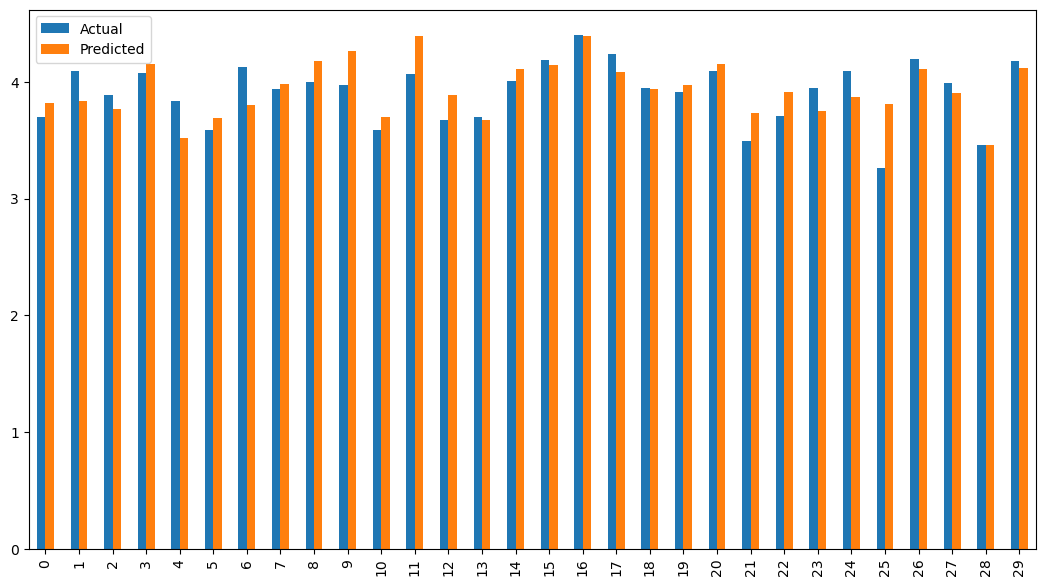

In [53]:
pred1.head(30).plot(kind='bar', figsize=(13, 7))

In [54]:
#try to improve the result:

In [55]:
X2 = X1.copy()

In [56]:
X2['Style'] = X2['Primary_Style']+X2['Main_Style']
X2['Reviews+Ratings'] = X2['Num_of_reviews']+X2['Num_of_ratings']
X2 = X2.drop(['Main_Style', 'Primary_Style', 'Num_of_reviews', 'Num_of_ratings'], axis=1)

In [57]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state = 42)

In [58]:
#train model
trained_model = LinearRegression()
trained_model.fit(X_train2,y_train2)

LinearRegression()

In [59]:
predictions2 = trained_model.predict(X_test2)

In [60]:
r2_score(y_test2, predictions2)

0.3306762974513082

In [61]:
#try diffrent ml algo - random forest regressor

In [99]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X2, y, test_size=0.2, random_state = 42)

In [106]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train3,y_train3)

RandomForestRegressor(random_state=42)

In [107]:
predictions3 = rf.predict(X_test3)

In [108]:
r2_score(y_test3, predictions3)

0.6045053553153089

In [109]:
pred3 = pd.DataFrame({'Actual': y_test3.tolist(), 'Predicted': predictions3.tolist()})
pred3.head(15)

,Actual,Predicted
0,3.70,3.6697
1,4.09,3.8180
2,3.89,3.8349
3,4.08,3.9878
4,3.84,3.3412
5,3.59,3.5033
6,4.13,3.8269
7,3.94,3.8815
8,4.00,4.2243
9,3.97,4.1171


<AxesSubplot:>

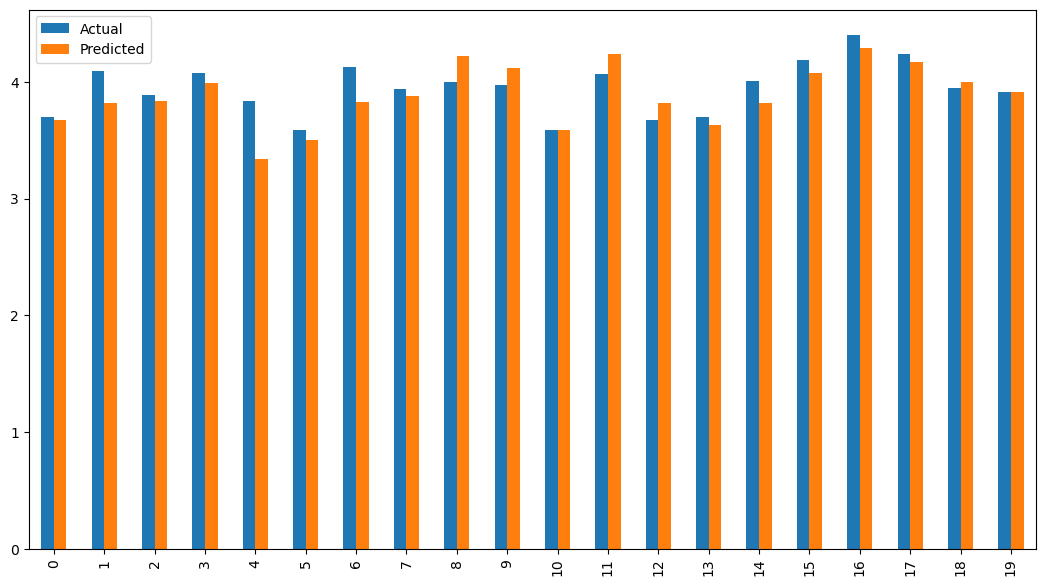

In [110]:
pred3.head(20).plot(kind='bar', figsize=(13, 7))